<a href="https://colab.research.google.com/github/romqn1999/Predict-price-after-pattern/blob/main/Predict_price_after_pattern.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving NOK_2000-01-01 00_00_00_2021-05-22_30_data_patterns.csv to NOK_2000-01-01 00_00_00_2021-05-22_30_data_patterns.csv
Saving NVDA_2000-01-01 00_00_00_2021-05-22_30_data_patterns.csv to NVDA_2000-01-01 00_00_00_2021-05-22_30_data_patterns.csv
Saving F_2000-01-01 00_00_00_2021-05-22_30_data_patterns.csv to F_2000-01-01 00_00_00_2021-05-22_30_data_patterns.csv
Saving ETH-USD_2000-01-01 00_00_00_2021-05-22_30_data_patterns.csv to ETH-USD_2000-01-01 00_00_00_2021-05-22_30_data_patterns.csv
Saving AMD_2000-01-01 00_00_00_2021-05-22_30_data_patterns.csv to AMD_2000-01-01 00_00_00_2021-05-22_30_data_patterns.csv
Saving BABA_2000-01-01 00_00_00_2021-05-22_30_data_patterns.csv to BABA_2000-01-01 00_00_00_2021-05-22_30_data_patterns.csv
Saving BA_2000-01-01 00_00_00_2021-05-22_30_data_patterns.csv to BA_2000-01-01 00_00_00_2021-05-22_30_data_patterns.csv
Saving BTC-USD_2000-01-01 00_00_00_2021-05-22_30_data_patterns.csv to BTC-USD_2000-01-01 00_00_00_2021-05-22_30_data_patterns.csv
Saving KO_

## Import packages

In [5]:
import math
import matplotlib.pyplot as plt
import keras
import numpy as np
import random
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras import optimizers
from keras.optimizers import Adagrad, Adadelta, RMSprop, Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

## Get data at pattern for training & testing

In [7]:
import io
import pandas as pd

price_patterns_df = pd.DataFrame()
for filename in uploaded.keys():
    print(filename)
    if 'data_patterns.csv' not in filename:
        print('Skipping file', filename)
        continue
    df = pd.read_csv(io.StringIO(uploaded[filename].decode('utf-8')),
                     header=None)
    price_patterns_df = price_patterns_df.append(df)

price_patterns_df = price_patterns_df.sample(frac=1).reset_index(drop=True)
price_patterns_df

NOK_2000-01-01 00_00_00_2021-05-22_30_data_patterns.csv
NVDA_2000-01-01 00_00_00_2021-05-22_30_data_patterns.csv
F_2000-01-01 00_00_00_2021-05-22_30_data_patterns.csv
ETH-USD_2000-01-01 00_00_00_2021-05-22_30_data_patterns.csv
AMD_2000-01-01 00_00_00_2021-05-22_30_data_patterns.csv
BABA_2000-01-01 00_00_00_2021-05-22_30_data_patterns.csv
BA_2000-01-01 00_00_00_2021-05-22_30_data_patterns.csv
BTC-USD_2000-01-01 00_00_00_2021-05-22_30_data_patterns.csv
KO_2000-01-01 00_00_00_2021-05-22_30_data_patterns.csv
AABB_2000-01-01 00_00_00_2021-05-22_30_data_patterns.csv
AAL_2000-01-01 00_00_00_2021-05-22_30_data_patterns.csv
AA_2000-01-01 00_00_00_2021-05-22_30_data_patterns.csv
VICI_2000-01-01 00_00_00_2021-05-22_30_data_patterns.csv
NFLX_2000-01-01 00_00_00_2021-05-18_30_data_patterns.csv
FB_2000-01-01 00_00_00_2021-05-18_30_data_patterns.csv
AMZN_2000-01-01 00_00_00_2021-05-18_30_data_patterns.csv
TSLA_2000-01-01 00_00_00_2021-05-18_30_data_patterns.csv
BB_2000-01-01 00_00_00_2021-05-18_30_da

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
0,80.957069,80.620651,82.711258,85.859192,85.330528,87.204872,87.084717,87.469200,84.705750,87.973831,90.064438,90.833397,91.386093,90.112503,90.953552,90.280708,91.121758,95.062683,92.347290,94.774323,94.389839,91.986839,91.914749,93.524757,92.155052,92.491470,93.789093,93.692970,93.212372,91.914749,90.689217
1,17.010000,16.750000,16.549999,16.639999,16.940001,16.860001,17.959999,18.459999,19.200001,18.940001,19.490000,18.740000,19.040001,19.260000,19.379999,19.750000,19.860001,19.299999,18.590000,18.570000,19.080000,19.360001,19.799999,18.780001,18.719999,19.340000,19.120001,19.510000,19.000000,19.820000,20.410000
2,7.350000,7.160000,7.070000,7.070000,6.940000,7.070000,7.020000,6.910000,6.710000,6.690000,6.650000,6.520000,6.720000,7.190000,7.150000,7.460000,7.420000,7.430000,7.560000,7.250000,7.420000,7.210000,6.910000,6.460000,6.310000,6.600000,7.000000,7.140000,7.500000,7.860000,8.270000
3,55.049999,55.299999,56.560001,56.049999,53.820000,55.480000,55.380001,56.959999,57.590000,57.430000,56.529999,55.040001,53.189999,52.439999,48.799999,49.860001,48.900002,48.259998,47.770000,48.250000,46.970001,45.950001,45.770000,45.130001,45.080002,45.580002,45.770000,45.209999,45.610001,47.290001,48.110001
4,11.150000,11.010000,10.990000,11.100000,10.750000,10.560000,10.830000,10.830000,10.860000,11.080000,10.860000,11.150000,11.330000,11.350000,11.180000,11.250000,11.450000,11.430000,11.310000,11.280000,11.380000,11.380000,11.330000,10.960000,10.820000,11.040000,10.960000,11.110000,11.430000,11.490000,11.240000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2838,20.424999,20.680000,20.700001,20.639999,20.620001,20.584999,20.480000,20.395000,20.290001,20.125000,20.139999,20.139999,19.865000,19.934999,19.855000,19.900000,19.930000,19.855000,19.655001,19.885000,20.209999,20.355000,20.195000,20.080000,20.195000,20.405001,20.264999,20.430000,20.650000,20.735001,20.565001
2839,32.134998,31.809999,32.305000,32.055000,31.695000,31.584999,32.349998,32.450001,32.250000,31.995001,32.070000,32.195000,32.415001,32.325001,32.424999,31.950001,32.369999,32.669998,32.849998,32.654999,32.744999,32.794998,32.790001,32.535000,32.680000,32.724998,32.750000,32.884998,32.610001,31.934999,31.745001
2840,138.160004,138.270004,137.789993,135.929993,135.699997,136.369995,139.130005,139.190002,139.449997,141.350006,141.050003,140.330002,141.460007,142.119995,142.149994,141.449997,141.250000,141.500000,141.979996,142.410004,142.470001,143.440002,143.509995,142.630005,142.100006,143.770004,145.369995,144.289993,145.119995,142.789993,142.350006
2841,4.150000,4.360000,4.414286,4.390000,4.178571,4.071429,4.047143,4.228571,4.138571,4.770000,4.910000,4.874286,5.051429,5.025714,5.100000,5.085714,5.090000,5.378571,5.387143,5.227143,5.214286,5.288571,4.392857,4.378571,4.157143,4.144286,4.254286,4.230000,4.087143,4.005714,3.954286


In [8]:
#@title Separate into input and output columns: Get data: X and y

X_df = price_patterns_df[price_patterns_df.columns[:-1]]
y_df = price_patterns_df[price_patterns_df.columns[-1:]]
print(X_df)
print(y_df)

X_data = X_df.values
y_data = y_df.values
print(X_data)
print(y_data)

              0           1           2   ...          27          28          29
0      80.957069   80.620651   82.711258  ...   93.692970   93.212372   91.914749
1      17.010000   16.750000   16.549999  ...   19.510000   19.000000   19.820000
2       7.350000    7.160000    7.070000  ...    7.140000    7.500000    7.860000
3      55.049999   55.299999   56.560001  ...   45.209999   45.610001   47.290001
4      11.150000   11.010000   10.990000  ...   11.110000   11.430000   11.490000
...          ...         ...         ...  ...         ...         ...         ...
2838   20.424999   20.680000   20.700001  ...   20.430000   20.650000   20.735001
2839   32.134998   31.809999   32.305000  ...   32.884998   32.610001   31.934999
2840  138.160004  138.270004  137.789993  ...  144.289993  145.119995  142.789993
2841    4.150000    4.360000    4.414286  ...    4.230000    4.087143    4.005714
2842   14.310000   14.040000   13.920000  ...   13.730000   14.200000   14.360000

[2843 rows x 30

In [9]:
#@title Preprocess & split data for train model
# Train, test split
train_ratio = 0.8 #@param {type:"number"}
if train_ratio < 0 or  train_ratio > 1:
    train_ratio = 0.8
n_data = len(X_data)
n_train = int(train_ratio * n_data)
n_test = n_data - n_train
# Feature Scaling
scale_method = "MinMax" #@param ["None", "MinMax"]

X_train, y_train = X_data[: n_train], y_data[: n_train]
X_test, y_test = X_data[n_train:], y_data[n_train:]
if scale_method == 'MinMax':
    sc_train = MinMaxScaler(feature_range = (0, 1))
    X_train_scaled = sc_train.fit_transform(X_train.T).T
    y_train_scaled = sc_train.transform(y_train.T).T
    sc_test = MinMaxScaler(feature_range = (0, 1))
    X_test_scaled = sc_test.fit_transform(X_test.T).T
    y_test_scaled = sc_test.transform(y_test.T).T
    # X_train, y_train = X_train_scaled, y_train_scaled
    # X_test, y_test = X_test_scaled, y_test_scaled
print(X_train.shape, y_train.shape)
print(X_train_scaled.shape, y_train_scaled.shape)
print(X_test.shape, y_test.shape)
print(X_test_scaled.shape, y_test_scaled.shape)

# print(X_train)
# print(y_train)

(2274, 30) (2274, 1)
(2274, 30) (2274, 1)
(569, 30) (569, 1)
(569, 30) (569, 1)


## LSTM model

### Build model

In [10]:
#@title Build & fit model
lstm_units = 50 #@param {type:"integer"}
dropout_prob = 0.5 #@param {type:"number"}
epochs = 8000 #@param {type:"integer"}
batch_size = 4096 #@param {type:"integer"}

model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units=lstm_units,
               return_sequences=True,
               input_shape=(X_data.shape[1], 1)))
model.add(Dropout(dropout_prob))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units=lstm_units,
               return_sequences=True))
model.add(Dropout(dropout_prob))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units=lstm_units,
               return_sequences=True))
model.add(Dropout(dropout_prob))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units=lstm_units))
model.add(Dropout(dropout_prob))
# Adding the output layer
model.add(Dense(units=1))

# Adam optimizer
opt = Adam(learning_rate=0.0005, epsilon=1e-06, decay=1e-06)
# # PiecewiseConstantDecay optimizer
# boundaries = [200, 800, 2000, 4000]
# values = [0.01, 0.001, 0.0005, 0.0001, 0.00001]
# opt = keras.optimizers.schedules.PiecewiseConstantDecay(
#     boundaries, values)
# Compiling the RNN
# model.compile(optimizer = opt, loss = 'mean_squared_error')
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

### Train model

In [11]:
def train_lstm(model, X_train, y_train, epochs, batch_size):
    # We have now reshaped the data into the following format (#values, #time-steps, #1 dimensional output).
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    y_train = np.reshape(y_train, (y_train.shape[0], 1))

    # Fitting the RNN to the Training set
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)
    return model

model = train_lstm(model, X_train_scaled, y_train_scaled, epochs, batch_size)
model.save('LSTM_predict_price_pattern')

Streaming output truncated to the last 5000 lines.
Epoch 5501/8000
1/1 [==============================] - 1s 1s/step - loss: 0.0120
Epoch 5502/8000
1/1 [==============================] - 1s 1s/step - loss: 0.0119
Epoch 5503/8000
1/1 [==============================] - 1s 1s/step - loss: 0.0120
Epoch 5504/8000
1/1 [==============================] - 2s 2s/step - loss: 0.0122
Epoch 5505/8000
1/1 [==============================] - 1s 1s/step - loss: 0.0117
Epoch 5506/8000
1/1 [==============================] - 1s 1s/step - loss: 0.0118
Epoch 5507/8000
1/1 [==============================] - 1s 1s/step - loss: 0.0119
Epoch 5508/8000
1/1 [==============================] - 1s 1s/step - loss: 0.0121
Epoch 5509/8000
1/1 [==============================] - 1s 1s/step - loss: 0.0118
Epoch 5510/8000
1/1 [==============================] - 1s 1s/step - loss: 0.0120
Epoch 5511/8000
1/1 [==============================] - 1s 1s/step - loss: 0.0113
Epoch 5512/8000
1/1 [==============================] - 1s 

INFO:tensorflow:Assets written to: LSTM_predict_price_pattern/assets


INFO:tensorflow:Assets written to: LSTM_predict_price_pattern/assets


### Test model

In [12]:
def get_direction(pre, cur, min_change=1):
    if abs(pre - cur) < min_change:
        return 0
    else:
        if pre < cur:
            return 1
        else:
            return -1

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

def calc_confusion_matrix(X, y_true, y_pred, min_change=1):
    assert len(X) == len(y_true)
    assert len(X) == len(y_pred)
    n = len(y_true)
    y_true_direction = [get_direction(X[i][-1], y_true[i], min_change) for i in range(n)]
    y_pred_direction = [get_direction(X[i][-1], y_pred[i], min_change) for i in range(n)]
    cm = confusion_matrix(y_true_direction, y_pred_direction, labels=[-1, 0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=[-1, 0, 1])
    disp.plot()
    return cm

def calc_accuracy(X, y_true, y_pred, min_change=1):
    assert len(X) == len(y_true)
    assert len(X) == len(y_pred)
    n = len(y_true)
    y_true_direction = [get_direction(X[i][-1], y_true[i], min_change) for i in range(n)]
    y_pred_direction = [get_direction(X[i][-1], y_pred[i], min_change) for i in range(n)]
    return accuracy_score(y_true_direction, y_pred_direction)

In [14]:
!unzip /content/LSTM_predict_price_pattern_model.zip

unzip:  cannot find or open /content/LSTM_predict_price_pattern_model.zip, /content/LSTM_predict_price_pattern_model.zip.zip or /content/LSTM_predict_price_pattern_model.zip.ZIP.


In [15]:
# X_test = X_train
lstm_model = keras.models.load_model("LSTM_predict_price_pattern")

In [16]:
#@title Define some params for make decision { run: "auto" }
min_price_change = 0 #@param {type:"number"}


In [17]:
predicted_stock_price = lstm_model.predict(np.reshape(X_test_scaled, (X_test_scaled.shape[0], X_test_scaled.shape[1], 1)))
if scale_method == 'MinMax':
    predicted_stock_price = sc_test.inverse_transform(predicted_stock_price.T).T
    # y_test = sc_test.inverse_transform(y_test.T).T

In [18]:
y_test, predicted_stock_price

(array([[   8.09000015],
        [  42.09500122],
        [  21.56999969],
        [  49.7842865 ],
        [  29.54000092],
        [ 109.37000275],
        [  53.22000122],
        [  81.01999664],
        [ 128.78999329],
        [   9.18000031],
        [   7.27083302],
        [  18.11000061],
        [   6.5       ],
        [  27.97999954],
        [ 151.27999878],
        [   6.88999987],
        [  95.06268311],
        [   1.94000006],
        [   6.23999977],
        [   3.36999989],
        [  62.52999878],
        [  37.22999954],
        [  42.09999847],
        [ 522.61999512],
        [  12.64999962],
        [  37.22999954],
        [  98.73999786],
        [   9.11999989],
        [  21.43475914],
        [ 200.75      ],
        [   5.48400021],
        [  12.34615421],
        [  92.76000214],
        [   3.72000003],
        [ 177.28999329],
        [  22.22999954],
        [   7.67999983],
        [  54.13000107],
        [  22.27000046],
        [   8.25      ],


In [19]:
float_formatter = "{:.2f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})
print(y_test - predicted_stock_price)
print(max(abs(y_test - predicted_stock_price)))

[[0.17]
 [-1.55]
 [0.08]
 [-0.17]
 [-1.04]
 [-1.16]
 [-2.63]
 [-1.00]
 [-2.10]
 [-0.21]
 [-0.44]
 [0.06]
 [0.03]
 [0.00]
 [-0.14]
 [0.01]
 [6.04]
 [-0.36]
 [0.02]
 [0.06]
 [-0.26]
 [0.83]
 [0.32]
 [-10.81]
 [0.24]
 [0.03]
 [-3.13]
 [-0.04]
 [0.06]
 [-0.06]
 [0.03]
 [-0.09]
 [-0.04]
 [-0.03]
 [1.18]
 [-0.45]
 [0.06]
 [-0.07]
 [-0.58]
 [-0.02]
 [0.08]
 [0.62]
 [1.06]
 [-0.01]
 [-0.01]
 [-0.77]
 [0.29]
 [0.26]
 [0.05]
 [-0.00]
 [-0.02]
 [0.02]
 [0.07]
 [0.40]
 [0.03]
 [-0.97]
 [-0.28]
 [-0.08]
 [3.07]
 [0.76]
 [0.48]
 [0.81]
 [-0.08]
 [0.03]
 [-0.05]
 [-0.06]
 [1.36]
 [-0.61]
 [6.10]
 [0.35]
 [0.04]
 [-0.18]
 [0.82]
 [-2.27]
 [0.06]
 [-0.07]
 [-2.66]
 [3.20]
 [0.04]
 [-2.94]
 [1.20]
 [0.20]
 [-0.01]
 [0.00]
 [-0.01]
 [0.01]
 [1.07]
 [-0.02]
 [-0.01]
 [0.22]
 [0.01]
 [-0.88]
 [0.51]
 [0.02]
 [0.03]
 [-0.26]
 [0.07]
 [0.01]
 [-0.27]
 [0.04]
 [-0.06]
 [0.18]
 [0.52]
 [-0.88]
 [1.74]
 [-0.63]
 [0.93]
 [0.74]
 [-3.13]
 [-1.63]
 [0.58]
 [0.05]
 [-0.02]
 [0.03]
 [3.04]
 [0.33]
 [0.32]
 [0.03]
 [

rmse: 3.7520663046611724 mape: 1.7919920500815236
confusion_matrix: [[195   0  84]
 [  0   0   0]
 [104   0 186]]
acc: 0.6695957820738138


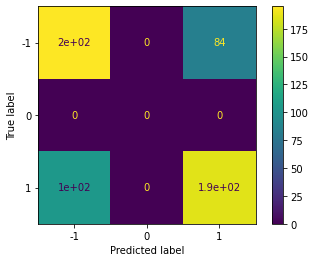

In [20]:
# Calculate RMSE and MAPE
from sklearn.metrics import mean_squared_error

def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

rmse = math.sqrt(mean_squared_error(y_test, predicted_stock_price))
mape = get_mape(y_test, predicted_stock_price)
conf_matrix = calc_confusion_matrix(X_test, y_test, predicted_stock_price, min_price_change)
acc = calc_accuracy(X_test, y_test, predicted_stock_price, min_price_change)

print('rmse:', rmse, 'mape:', mape)
print('confusion_matrix:', conf_matrix)
print('acc:', acc)

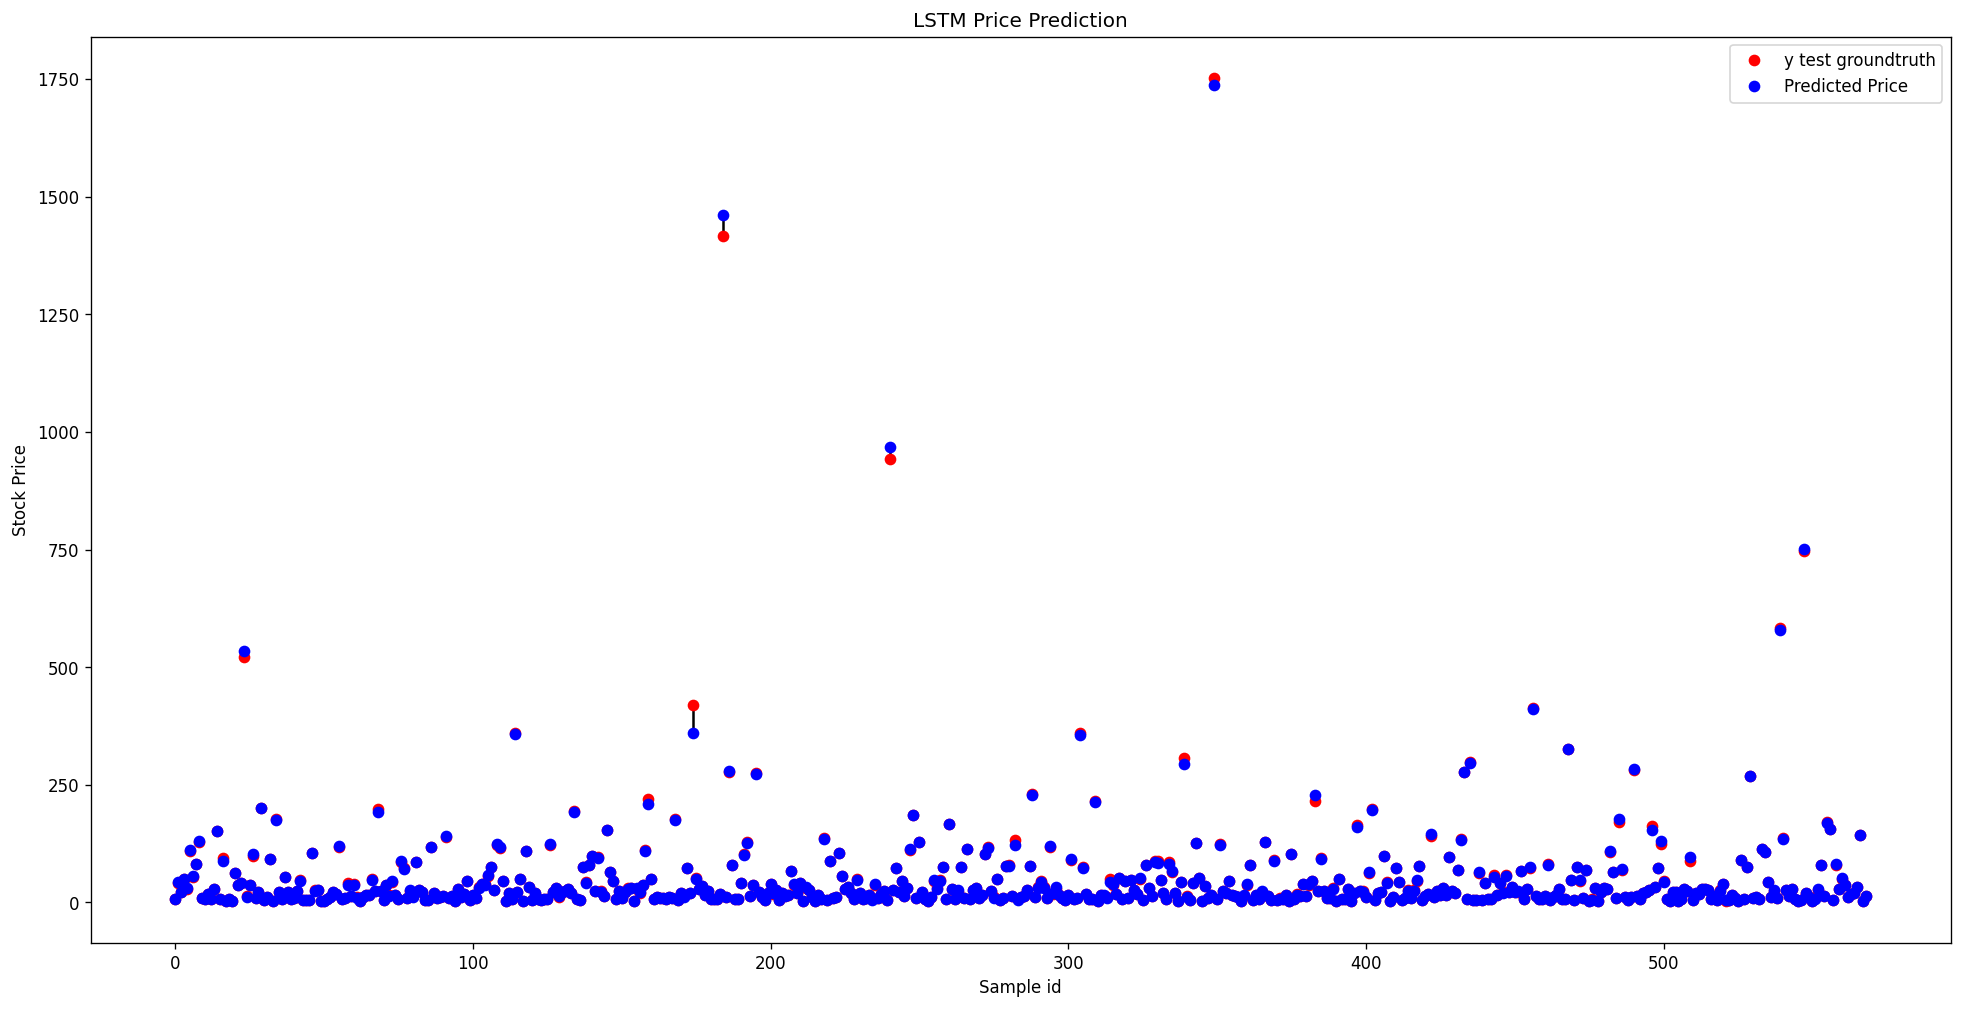

In [21]:
# Visualising the results
plt.figure(figsize=(20, 10), dpi= 120, facecolor='w', edgecolor='k')
plt.plot(range(len(y_test)), y_test, 'o', color = 'red', label = 'y test groundtruth')
plt.plot(range(len(y_test)), predicted_stock_price, 'o', color = 'blue', label = 'Predicted Price')
plt.vlines(range(len(y_test)), np.minimum(y_test, predicted_stock_price), np.maximum(y_test, predicted_stock_price))
# plt.xticks(np.arange(0,459,50))
plt.title('LSTM Price Prediction')
plt.xlabel('Sample id')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

## XGBoost model

### Build model

In [22]:
#@title Build model
seed = 100 #@param {type:"integer"}
n_estimators = 100 #@param {type:"integer"}
max_depth = 3 #@param {type:"integer"}
learning_rate = 0.1 #@param {type:"number"}
min_child_weight = 0 #@param {type:"number"}
subsample = 1 #@param {type:"number"}
colsample_bytree = 1 #@param {type:"number"}
colsample_bylevel = 1 #@param {type:"number"}
gamma = 0 #@param {type:"number"}
from xgboost import XGBRegressor

xgbmodel = XGBRegressor(seed=seed,
                        n_estimators=n_estimators,
                        max_depth=max_depth,
                        learning_rate=learning_rate,
                        min_child_weight=min_child_weight,
                        subsample=subsample,
                        colsample_bytree=colsample_bytree,
                        colsample_bylevel=colsample_bylevel,
                        gamma=gamma)

### Train the model

In [23]:
xgbmodel.fit(np.reshape(X_train_scaled, (X_train_scaled.shape[0], X_train_scaled.shape[1])), np.reshape(y_train_scaled, (y_train_scaled.shape[0])))

[07:57:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=0, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=100,
             silent=None, subsample=1, verbosity=1)

### Test model

In [24]:
predicted_stock_price = xgbmodel.predict(np.reshape(X_test_scaled, (X_test_scaled.shape[0], X_test_scaled.shape[1])))
predicted_stock_price = np.reshape(predicted_stock_price, (predicted_stock_price.shape[0], 1))
if scale_method == 'MinMax':
    predicted_stock_price = sc_test.inverse_transform(predicted_stock_price.T).T
    # y_test = sc_test.inverse_transform(y_test.T).T

In [25]:
float_formatter = "{:.2f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})
print(y_test - predicted_stock_price)
print(max(abs(y_test - predicted_stock_price)))

[[0.19]
 [-0.85]
 [-0.31]
 [-0.29]
 [0.07]
 [-1.25]
 [-1.89]
 [-0.29]
 [-1.07]
 [-0.36]
 [0.63]
 [0.14]
 [0.01]
 [0.06]
 [-0.70]
 [0.08]
 [3.12]
 [0.00]
 [-0.11]
 [0.00]
 [-0.56]
 [1.50]
 [0.15]
 [-6.43]
 [0.27]
 [-0.01]
 [-1.11]
 [0.04]
 [-0.11]
 [0.61]
 [0.11]
 [-0.03]
 [0.35]
 [0.07]
 [2.24]
 [-0.40]
 [-0.18]
 [-0.09]
 [-1.10]
 [0.04]
 [-0.10]
 [0.15]
 [0.53]
 [0.07]
 [0.00]
 [-0.22]
 [0.61]
 [0.37]
 [-0.27]
 [0.02]
 [0.09]
 [0.18]
 [0.09]
 [0.67]
 [0.01]
 [-1.00]
 [-0.32]
 [-0.25]
 [3.12]
 [0.60]
 [0.29]
 [0.49]
 [0.10]
 [0.04]
 [0.55]
 [0.26]
 [1.59]
 [-0.25]
 [4.38]
 [0.04]
 [0.03]
 [0.10]
 [0.46]
 [-0.64]
 [0.15]
 [0.04]
 [-1.56]
 [5.25]
 [-0.05]
 [-2.89]
 [-0.13]
 [-1.25]
 [0.25]
 [0.09]
 [0.00]
 [-0.00]
 [-0.20]
 [0.00]
 [-0.14]
 [-0.20]
 [-0.13]
 [-0.41]
 [0.11]
 [0.02]
 [-0.09]
 [-0.30]
 [0.09]
 [0.16]
 [-0.29]
 [0.12]
 [0.26]
 [-0.11]
 [0.40]
 [-0.45]
 [1.06]
 [0.11]
 [0.99]
 [1.25]
 [0.42]
 [-2.76]
 [-0.20]
 [0.09]
 [0.00]
 [0.01]
 [-1.23]
 [0.03]
 [0.12]
 [-0.09]
 [1.24]


rmse: 2.584856268869408 mape: 1.6828544344427998
confusion_matrix: [[181   0  98]
 [  0   0   0]
 [141   0 149]]
acc: 0.5799648506151143


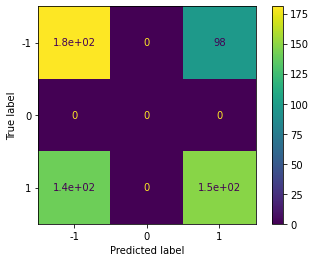

In [26]:
rmse = math.sqrt(mean_squared_error(y_test, predicted_stock_price))
mape = get_mape(y_test, predicted_stock_price)
conf_matrix = calc_confusion_matrix(X_test, y_test, predicted_stock_price, min_price_change)
acc = calc_accuracy(X_test, y_test, predicted_stock_price, min_price_change)

print('rmse:', rmse, 'mape:', mape)
print('confusion_matrix:', conf_matrix)
print('acc:', acc)

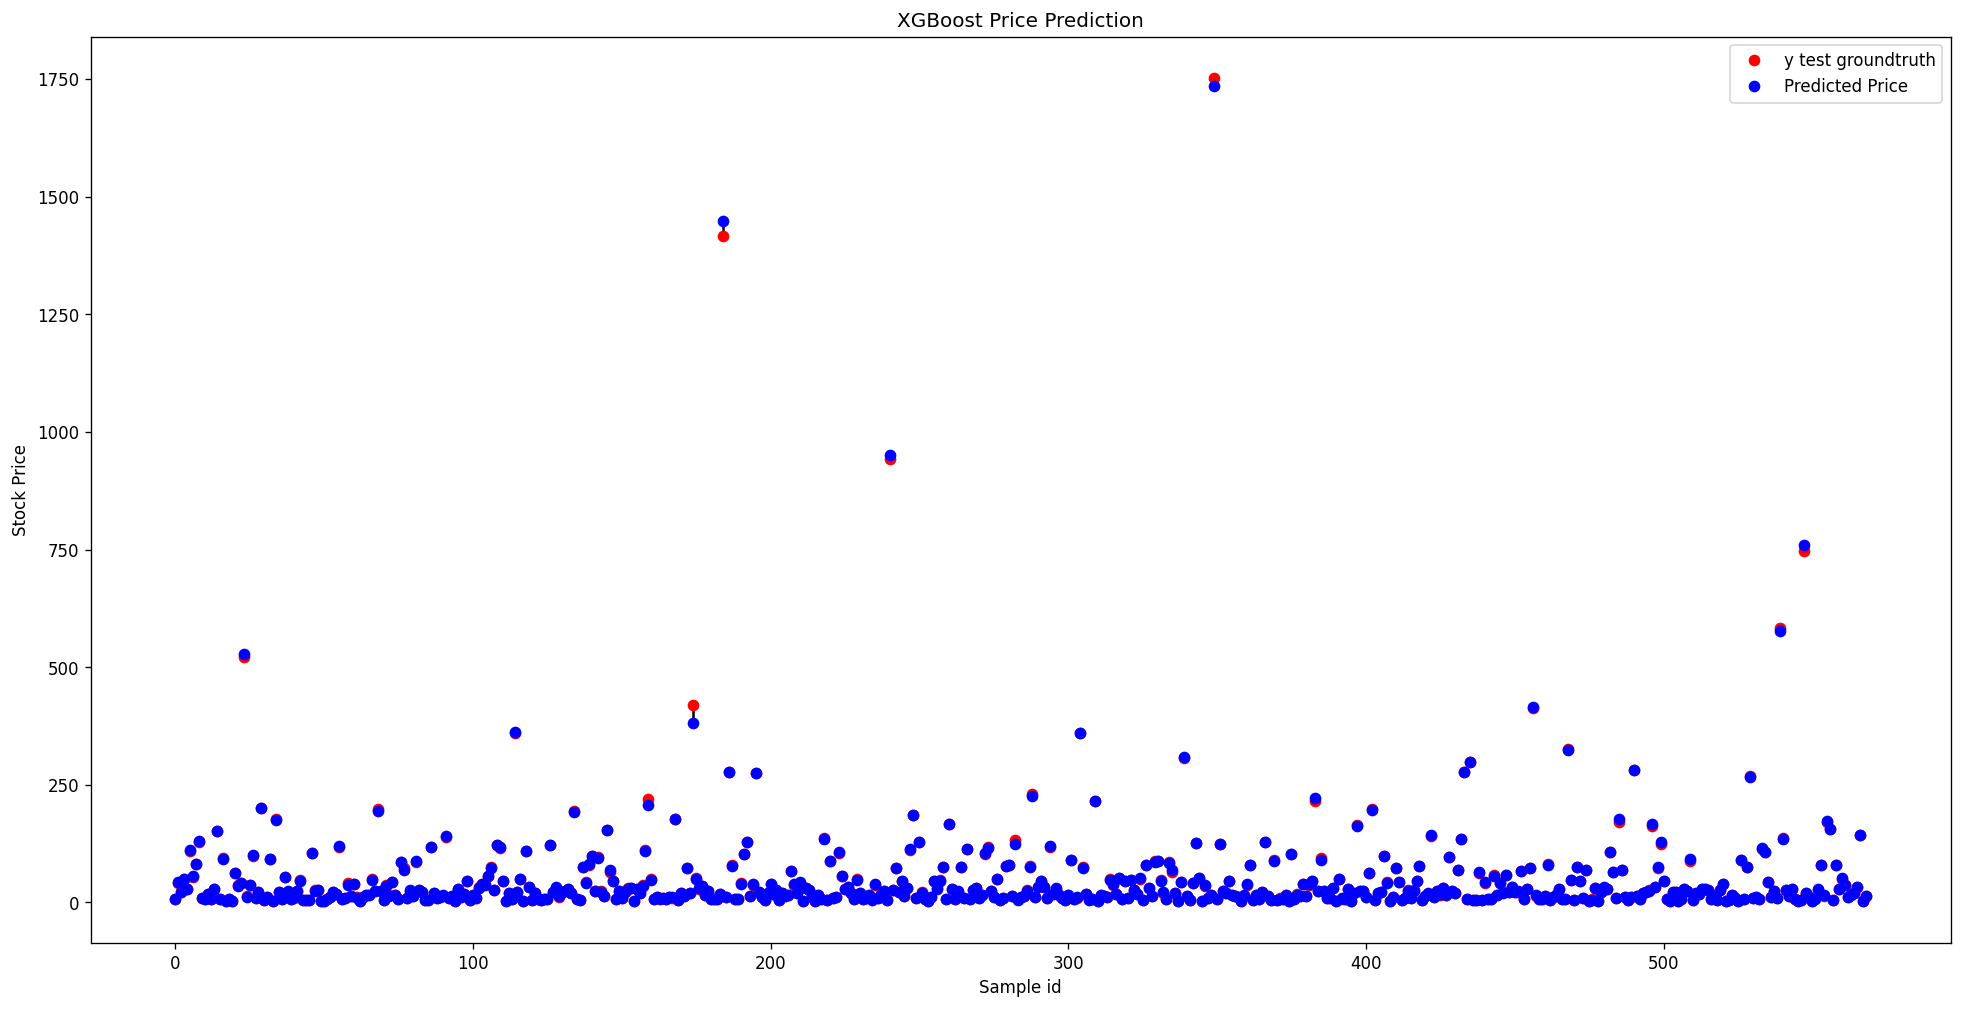

In [27]:
# Visualising the results
plt.figure(figsize=(20, 10), dpi= 120, facecolor='w', edgecolor='k')
plt.plot(range(len(y_test)), y_test, 'o', color = 'red', label = 'y test groundtruth')
plt.plot(range(len(y_test)), predicted_stock_price, 'o', color = 'blue', label = 'Predicted Price')
plt.vlines(range(len(y_test)), np.minimum(y_test, predicted_stock_price), np.maximum(y_test, predicted_stock_price))
# plt.xticks(np.arange(0,459,50))
plt.title('XGBoost Price Prediction')
plt.xlabel('Sample id')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [31]:
!zip -r /content/LSTM_predict_price_pattern_model.zip LSTM_predict_price_pattern

  adding: LSTM_predict_price_pattern/ (stored 0%)
  adding: LSTM_predict_price_pattern/variables/ (stored 0%)
  adding: LSTM_predict_price_pattern/variables/variables.index (deflated 69%)
  adding: LSTM_predict_price_pattern/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: LSTM_predict_price_pattern/saved_model.pb (deflated 91%)
  adding: LSTM_predict_price_pattern/assets/ (stored 0%)
